In [205]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

# Order Imbalance Strategy in Chinese Future Markets

# Introduction
This project is to replicate the paper from D.Shen(2015), who analysed the factor 'Order imbalance' to have a significant impact on the change in CSI300 Futures tick data backed in 2014. Here are his findings:

1. Developed a trading strategy by fitting the order imbalance factor model to forecast 10 seconds mid price change.
2. Model shows high profitability when trading signal is greater than 0.2 ticks.
3. Profits made by the strategy are strongly correlated with the total trading volume in the market

Additional findings:
1. Improved trading signal by extending model to 2 more factors : Order imbalance ratio and mid price basis mean reversion, and divided variables by bid-ask spread. 
2. Large spread indicates low price change
3. Trading parameters optimization : Forecast window for average change and trading threshold were closer to 5 and 0.15 respectively

Results from D.Shen(2015):
1. Average Correlation coefficeint of OI and instantaneous mid-price change : 0.3935
2. Fitting a linear regression model gives average daily R-squared : 0.155
3. Correlation between 10s interval between price change and VOI R-squared: 0.6537
4. Variable samples proved to be stationary by ADF/KPSS test

# Step 1 : Identifying Objectives
The first step of this project is to define what we are looking for. In my own understanding, the whole research can guide us to potential trading strategy and we are about to find out whether the key factor fits well with the data. D.Shen(2015) has proven a significant amount of profit backing up by the linear model. That means the signal(alpha) has a robust performance in the CSI300 Future tick data. The next step is to perform data cleaning. It is crucially important because uncleaned data may lead to irregular results.

# Step 2 : Checking & tidying data
Facts about the SHFE tick data set:
1. Tick data from 00:00:00.000 to 23:59:59.500 GMT+8
2. Interval per each entry : 5ms difference(Snapshot data)
3. 16 Future contracts with 12 expiries & Multiple Option contracts(Not included in this research). e.g. RB1912 to RB2012
4. LEVEL 2 quote.
5. Volume and Turnover resets at 21:00:00.000 for all contracts, which means, volume and turnover counts from previous day's 21:00:00.000 for contracts that trades during night session.

There are some data cleaning procedures before we continue our analysis. 
1. The time is not in datetime format so we need to convert it to that. 
2. Filtering out option contracts because we are not comparing them in this project
3. Obtain only for Active contracts for the highest volume
4. NaN values need to be removed

In [188]:
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
import datetime as dt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#read file
df = pd.read_csv('ShfeMulti_20191031.csv', index_col=None, header=None)
df.columns = ['Timestamp','Contract', 'time','last_price','volume','turnover','open_interest', #rename column
              'BP1','BV1','AP1','AV1',
              'BP2','BV2','AP2','AV2',
              'BP3','BV3','AP3','AV3',
              'BP4','BV4','AP4','AV4',
              'BP5','BV5','AP5','AV5']

pd.set_option('display.float_format', '{:.2f}'.format) #Set display decimals


#Convert datetime object as Index
df = df.sort_values(['time'], ascending=True) #Sort time
df.time  = pd.to_datetime(df.time) #Convert time to datetime object
df.time  = pd.to_datetime(df.time).dt.strftime('%H:%M:%S.%f')##Remove Y/M/D , I only want H/M/S 

#obtain time from 09:00 - 15:00, Not including night session
df = df[(df.time >= '08:59:00.000') & (df.time <='15:00:00.500')]
df = df.set_index('time')#Set time as index

#Obtaining Active contract names 
#df = df[['Contract','volume','turnover', 'BP1','BV1','AP1','AV1']]
#filter out option contracts, more than 6 characters are options contracts
df = df[df['Contract'].str.len() <= 6]
#Filter in Active Contract, all contracts doesn't work...
df['Contract1'] = df.Contract.str.slice(start=0,stop =2)
df['Contract2'] = df.Contract.str.slice(start=2)
temp = df.groupby('Contract').max().reset_index()
temp= temp[['volume','Contract1','Contract']]
temp = temp[temp.volume == temp.groupby('Contract1')['volume'].transform('max')]
main = temp.Contract.to_numpy()
df = df[df['Contract'].isin(main)] 
df = df.sort_values(['time','Contract'], ascending=True)

#Remove NaNs 
df.dropna(inplace = True)

df.sort_values(['Contract1'], ascending=True)

df.head()

,Timestamp,Contract,last_price,volume,turnover,open_interest,BP1,BV1,AP1,AV1,BP2,BV2,AP2,AV2,BP3,BV3,AP3,AV3,BP4,BV4,AP4,AV4,BP5,BV5,AP5,AV5,Contract1,Contract2
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
08:59:00.500000,3283647182.29,wr2001,3660.00,0.00,0.00,30.00,3636.00,1.00,3690.00,1.00,3620.00,1.00,3720.00,1.00,3606.00,1.00,3760.00,1.00,3566.00,1.00,3786.00,1.00,3506.00,1.00,3880.00,2.00,wr,2001
09:00:00.500000,3283707180.75,ag1912,4352.00,663578.00,43350185370.00,811918.00,4351.00,110.00,4352.00,24.00,4350.00,1032.00,4353.00,5.00,4349.00,43.00,4354.00,62.00,4348.00,77.00,4355.00,18.00,4347.00,32.00,4356.00,451.00,ag,1912
09:00:00.500000,3283707180.77,al1912,13815.00,22590.00,1561775000.00,230674.00,13810.00,52.00,13815.00,13.00,13805.00,338.00,13820.00,68.00,13800.00,81.00,13825.00,29.00,13795.00,108.00,13830.00,59.00,13790.00,67.00,13835.00,186.00,al,1912
09:00:00.500000,3283707180.78,au1912,341.20,181304.00,61837871700.00,347730.00,341.05,7.00,341.20,15.00,341.00,6.00,341.25,53.00,340.95,4.00,341.30,5.00,340.90,15.00,341.35,10.00,340.85,102.00,341.40,8.00,au,1912
09:00:00.500000,3283707180.80,bu1912,2948.00,335662.00,9884005640.00,430862.00,2944.00,51.00,2948.00,2.00,2942.00,201.00,2950.00,47.00,2940.00,237.00,2952.00,158.00,2938.00,214.00,2954.00,149.00,2936.00,251.00,2956.00,254.00,bu,1912


# Step 2 : Factor Analysis
The key signal in this project is 'Volume Order Imbalance'(VOI) and Midprice. Let's compute it.

In [69]:
#Compute VOI, the signal
def VOI(df):
    delta_VB = [0];delta_VA = [0]
    t=0;u=0
    for t in range(1,len(df.index)):
        if df.BP1[t] < df.BP1[t-1]:
            delta_VB.append(0)
        elif df.BP1[t] == df.BP1[t-1]:
            delta_VB.append(df.BV1[t] - df.BV1[t-1])
        elif df.BP1[t] > df.BP1[t-1]:
            delta_VB.append(df.BV1[t])
    for u in range(1,len(df.index)):
        if df.AP1[u] < df.AP1[u-1]:
            delta_VA.append(df.AV1[u])
        elif df.AP1[u] == df.AP1[u-1]:
            delta_VA.append(df.AV1[u] - df.AV1[u-1])
        elif df.AP1[u] > df.AP1[u-1]:
            delta_VA.append(0)
    VOI = pd.Series(np.subtract(delta_VB,delta_VA))
    VOI.index = df.index
    return VOI

#Mid price , or we can fully utilitize the order book, VWAP(next step)
def midprice(df):
    midprice = (df.BP1 +df.AP1)/2
    return midprice

#Bid Ask Spread
def BAS(df):
    return (df.AP1 - df.BP1)

#Take best volume example rb 
rb = df[df.Contract1== 'rb']

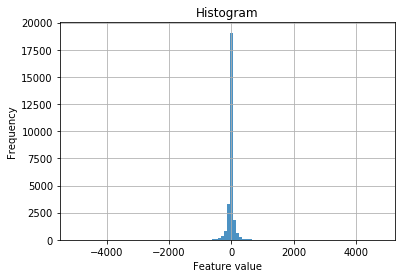

In [59]:
import matplotlib.pyplot as plt
from IPython.display import display
pd.Series(VOI(rb)).plot.hist(alpha=0.8, bins=100, grid=True, legend=None)  # Pandas helper function to plot a hist. Uses matplotlib under the hood.
plt.xlabel("Feature value")
plt.title("Histogram")
plt.show()

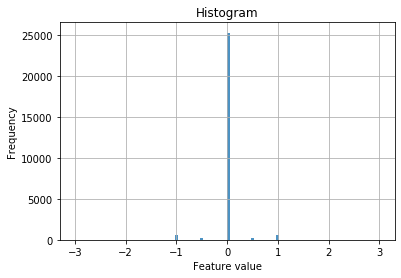

In [63]:
pd.Series(midprice(rb).diff()[1:]).plot.hist(alpha=0.8, bins=100, grid=True, legend=None)  # Pandas helper function to plot a hist. Uses matplotlib under the hood.
plt.xlabel("Feature value")
plt.title("Histogram")
plt.show()

#Noise vs Noise

### Statistical Analysis 
For time series data analysis, a few things need to be checked before we run the linear model. 

1. Normalization of midprice change
2. Autocorrelation a.k.a. Serial Correlation : Check similarity within time series
3. Stationarity (ADF test), Series can steadily accumulate positive returns. Reject Null Hypothesis if the series is stationary. 

Before we check those, we need to normalize the midprice change by their tick size since we are comparing data within contracts.

In [4]:

#Obtaining ticksize
def ticksize(df):
    x=df['BP1'].diff()
    x = x.replace(0, np.nan)
    x.dropna(inplace=True)
    return abs(x.value_counts().idxmax())

temp = df.groupby('Contract').apply(midprice).diff()/df.groupby('Contract').apply(ticksize)
df.groupby('Contract').apply(ticksize)

Contract
ag1912    1.00
al1912    5.00
au1912    0.05
bu1912    2.00
cu1912   10.00
fu2001    1.00
hc2001    1.00
ni1912   10.00
pb1912    5.00
rb2001    1.00
ru2001    5.00
sn2001   10.00
sp2001    2.00
ss2002    5.00
wr2001    1.00
zn1912    5.00
dtype: float64

Now have our change in midprice normalized against ticksize. We can conduct our analysis. The first one is **Correlation**. 

In [5]:
pd.set_option('display.float_format', '{:.4f}'.format)
def cor(df):
    cor = np.corrcoef(np.diff(midprice(df))/ticksize(df),VOI(df)[1:])[1,0]
    return cor

correlation_table = pd.DataFrame(df.groupby('Contract').apply(cor))
print(correlation_table)

              0
Contract       
ag1912   0.2700
al1912   0.2562
au1912   0.2771
bu1912   0.2496
cu1912   0.2059
fu2001   0.4739
hc2001   0.2714
ni1912   0.3942
pb1912   0.2873
rb2001   0.2272
ru2001   0.3217
sn2001   0.3390
sp2001   0.2963
ss2002   0.1850
wr2001   0.2105
zn1912   0.2766


### Autocorrelation 


In [6]:
#Autocorrelation coefficient for dM with lag from 0 to 5
def dM_autocor(df):
    temp = midprice(df).diff()/ticksize(df)
    autocor = pd.Series([round(temp.autocorr(lag = i),2) for i in range(0,6)])
    return autocor

autocorrr = df.groupby('Contract').apply(dM_autocor)
autocorrr

,0,1,2,3,4,5
Contract,,,,,,
ag1912,1.0000,-0.1100,-0.0500,-0.0300,-0.0100,-0.0200
al1912,1.0000,-0.0700,-0.1000,-0.0800,-0.0100,-0.0300
au1912,1.0000,-0.1900,-0.0600,-0.0400,-0.0300,-0.0000
bu1912,1.0000,-0.0800,-0.0800,-0.0200,-0.0100,-0.0200
cu1912,1.0000,-0.1800,-0.0400,-0.0100,-0.0300,-0.0300
fu2001,1.0000,-0.1100,-0.0500,-0.0200,-0.0400,-0.0100
hc2001,1.0000,-0.2300,-0.0300,-0.0100,-0.0100,-0.0100
ni1912,1.0000,-0.2000,0.0200,0.0300,0.0100,-0.0000
pb1912,1.0000,-0.1600,-0.0200,-0.0500,-0.0200,-0.0200


In [7]:
#Autocorrelation coefficient for VOI with lag from 0 to 5
def VOI_autocor(df):
    temp = VOI(df).diff()/ticksize(df)
    autocor = pd.Series([round(temp.autocorr(lag = i),2) for i in range(0,6)])
    return autocor

autocorrr = df.groupby('Contract').apply(dM_autocor)
autocorrr

,0,1,2,3,4,5
Contract,,,,,,
ag1912,1.0000,-0.1100,-0.0500,-0.0300,-0.0100,-0.0200
al1912,1.0000,-0.0700,-0.1000,-0.0800,-0.0100,-0.0300
au1912,1.0000,-0.1900,-0.0600,-0.0400,-0.0300,-0.0000
bu1912,1.0000,-0.0800,-0.0800,-0.0200,-0.0100,-0.0200
cu1912,1.0000,-0.1800,-0.0400,-0.0100,-0.0300,-0.0300
fu2001,1.0000,-0.1100,-0.0500,-0.0200,-0.0400,-0.0100
hc2001,1.0000,-0.2300,-0.0300,-0.0100,-0.0100,-0.0100
ni1912,1.0000,-0.2000,0.0200,0.0300,0.0100,-0.0000
pb1912,1.0000,-0.1600,-0.0200,-0.0500,-0.0200,-0.0200


We can see autocorrelation for both exogenous and endogenous variable all vanish to zero as lag increases. Hence it shows that the time series is persistent.

### Stationarity
The first values gives the ADF test statistic, the second value returns the P-value. If P-value is 0.000 , that means reject Null hypothesis at 99%. Thus the time series is stationary.

In [35]:
from statsmodels.tsa.stattools import adfuller
#For dM
def dM_adf_test(df):
    x = midprice(df).diff()[1:]
    result = adfuller(x)
    l = pd.Series([round(result[0],4), round(result[1],4)])
    return l

df.groupby('Contract').apply(dM_adf_test)

,0,1
Contract,,
ag1912,-44.1018,0.0000
al1912,-24.8968,0.0000
au1912,-26.8083,0.0000
bu1912,-36.6114,0.0000
cu1912,-37.5743,0.0000
fu2001,-34.5356,0.0000
hc2001,-43.0506,0.0000
ni1912,-51.5021,0.0000
pb1912,-39.2873,0.0000


In [36]:
#For VOI
def VOI_adf_test(df):
    x = VOI(df)
    result = adfuller(x)
    l = [round(result[0],4), round(result[1],4)]
    return l
df.groupby('Contract').apply(VOI_adf_test)

Contract
ag1912    [-33.4823, 0.0]
al1912    [-33.0076, 0.0]
au1912    [-62.0019, 0.0]
bu1912    [-18.4634, 0.0]
cu1912    [-30.4053, 0.0]
fu2001    [-32.9547, 0.0]
hc2001    [-25.7603, 0.0]
ni1912     [-77.871, 0.0]
pb1912    [-21.6363, 0.0]
rb2001    [-20.9748, 0.0]
ru2001    [-30.7242, 0.0]
sn2001    [-15.3563, 0.0]
sp2001    [-60.0514, 0.0]
ss2002    [-53.3168, 0.0]
wr2001     [-4.9972, 0.0]
zn1912    [-28.7432, 0.0]
dtype: object

# Step 4 : Linear Modelling

In the next step I ran the linear OLS model to check how well does the model fit the snapshot data. We are separating the approach to a few stages : 
1. Benchmark Model (Random Walk)
$$ \Delta M_t = \alpha + \epsilon _t $$
2. Fit VOI as exogenous variable 
$$ \Delta M_t = \alpha + \beta OI_t + \epsilon  _t $$
3. Multifactor Model
$$ \Delta M_t = \alpha + \beta_{OI} \frac{OI_t}{S_t} + \beta_{OIR} \frac{OIR_t}{S_t} + \beta_{MPR} \frac{MPR_t}{S_t} + \epsilon  _t $$


### Random Walk Model (Benchmark)
In the following results, the following sequence of number represents as:

$$[ \alpha, t(\alpha)  , R^2 , Adj  R^2 ]$$

The MSE (Mean Squared Error) can specified as:
$$ MSE = \frac{1}{n} \sum_{k=1}^{n} (y - y_{pred})^2 $$

In [37]:
def ols(df):
    y = midprice(df).diff()[1:]/ticksize(df)
    x = np.array([1]*(len(df)-1))
    res = sm.OLS(y,x).fit()
    pred = res.predict(x)
    liss = pd.Series([round(res.params[0],4),round(res.tvalues[0],4), round(res.rsquared,6), round(res.rsquared_adj,6), np.mean((y - pred)**2)])
    return liss

model = df.groupby('Contract').apply(ols)
model.columns = ['Alpha', 't(alpha)','R^2','Adj R^2','MSE']
model

,Alpha,t(alpha),R^2,Adj R^2,MSE
Contract,,,,,
ag1912,0.0006,0.4269,-0.0000,-0.0000,0.0495
al1912,0.0005,0.3234,0.0000,0.0000,0.0179
au1912,0.0000,0.0156,0.0000,0.0000,0.0594
bu1912,0.0006,0.6518,0.0000,0.0000,0.0170
cu1912,-0.0006,-0.3616,-0.0000,-0.0000,0.0395
fu2001,0.0006,0.5687,0.0000,0.0000,0.0247
hc2001,-0.0012,-0.5848,0.0000,0.0000,0.0860
ni1912,-0.0009,-0.1500,0.0000,0.0000,0.8353
pb1912,-0.0017,-0.5228,-0.0000,-0.0000,0.0859


### VOI model
The following results are as follows:

$$[ \alpha, t(\alpha)  , \beta , t(\beta),  R^2 , Adj  R^2 ]$$


In [83]:
#Compute alpha, t-stats, beta, t-stats, R^2, adjusted R^2
def ols1(df):
    y = midprice(df).diff()[1:]/ticksize(df)
    x = sm.add_constant(VOI(df)[1:])
    res = sm.OLS(y,x).fit()
    pred = res.predict(x)
    liss = pd.Series([round(res.params.const,4),round(res.tvalues.const,4),round(res.params[0],4),
            round(res.tvalues[0],4), round(res.rsquared,4), round(res.rsquared_adj,4),np.mean((y - pred)**2)])
    return liss

model1 = df.groupby('Contract').apply(ols1)
model1.columns = ['Alpha', 't(alpha)','beta','t(beta)','R^2','Adj R^2','MSE']
model1


,Alpha,t(alpha),beta,t(beta),R^2,Adj R^2,MSE
Contract,,,,,,,
ag1912,-0.0000,-0.0340,0.0018,44.2820,0.0729,0.0729,0.0459
al1912,0.0002,0.1340,0.0020,24.5137,0.0656,0.0655,0.0167
au1912,0.0000,0.0174,0.0044,37.8393,0.0768,0.0767,0.0548
bu1912,-0.0004,-0.4610,0.0006,37.9167,0.0623,0.0622,0.0159
cu1912,-0.0011,-0.6133,0.0025,23.4184,0.0424,0.0423,0.0378
fu2001,-0.0008,-0.9557,0.0017,84.3206,0.2246,0.2245,0.0191
hc2001,-0.0006,-0.3017,0.0026,41.9357,0.0737,0.0736,0.0796
ni1912,0.0014,0.2733,0.0345,68.8303,0.1554,0.1554,0.7055
pb1912,0.0015,0.4928,0.0129,27.3983,0.0826,0.0825,0.0788


### Multifactor Model
We first compute factor Order Imbalance Ratio, Mean Reversion of Midprice and Bid Ask Spread for our Extended Model.

$$[ \alpha, t(\alpha)  , \beta_{OI} , t(\beta_{OI}),\beta_{OIR} , t(\beta_{OIR}),\beta_{MPR} , t(\beta_{MPR}),  R^2 , Adj  R^2 ]$$

In [84]:
#Order Imbalance Ratio
def OIR(df):
    return ((df.BV1 - df.AV1)/(df.BV1 + df.AV1))

#Mid price Reversion
def MPR(df):
    tp = [0]*len(df.index)
    mp = midprice(df)
    tp[0] = midprice(df)[0]
    for t in range(1, len(df.index)):
        if df.volume[t] != df.volume[t-1]:
            tp[t] = (df.turnover[t]-df.turnover[t-1])/((df.volume[t]-df.volume[t-1])*10)
        elif df.volume[t] == df.volume[t-1]:
            tp[t] = tp[t-1]
    return (tp - mp)


def ols2(df):
    y = midprice(df).diff()[1:]/ticksize(df)
    x = pd.DataFrame(VOI(df)/BAS(df))
    x['OIR'] = OIR(df)/BAS(df)
    x['MPR'] = MPR(df)/BAS(df)
    x = sm.add_constant(x)
    res = sm.OLS(y,x[1:]).fit()
    pred = res.predict(x)
    liss = pd.Series([round(res.params.const,4),round(res.tvalues.const,4),
            round(res.params[0],4),round(res.tvalues[0],4), 
            round(res.params.OIR,4),round(res.tvalues.OIR,4), 
            round(res.params.MPR,4),round(res.tvalues.MPR,4),
            round(res.rsquared,4), round(res.rsquared_adj,4),np.mean((y - pred)**2) ])
    return liss

model2 = df.groupby('Contract').apply(ols2)
model2.columns = ['Alpha', 't(alpha)',
                  'beta-OI','t(beta-OI)',
                  'beta-OIR','t(beta-OIR)',
                  'beta-MPR','t(beta-MPR)',
                  'R^2','Adj R^2','MSE']

model2

,Alpha,t(alpha),beta-OI,t(beta-OI),beta-OIR,t(beta-OIR),beta-MPR,t(beta-MPR),R^2,Adj R^2,MSE
Contract,,,,,,,,,,,
ag1912,-0.0393,-1.4870,0.0018,47.8640,-0.1516,-55.0989,0.0000,1.3958,0.1734,0.1733,0.0409
al1912,-0.0140,-0.4025,0.0098,25.4158,-0.3774,-23.5919,-0.0000,-0.4757,0.1223,0.1220,0.0157
au1912,-0.0019,-0.0958,0.0002,40.1380,-0.0076,-46.2011,0.0000,0.0735,0.1780,0.1778,0.0488
bu1912,0.0022,2.6822,0.0013,40.7840,-0.1482,-33.8606,-0.0257,-14.4018,0.1284,0.1282,0.0148
cu1912,-0.0069,-0.3038,0.0266,25.9056,-1.2091,-34.6490,-0.0000,-0.2061,0.1267,0.1265,0.0345
fu2001,0.0034,3.9519,0.0016,85.9305,-0.0817,-34.1743,-0.0389,-20.3561,0.2902,0.2901,0.0175
hc2001,0.0060,3.4257,0.0027,47.5595,-0.1432,-44.0028,-0.1098,-28.8091,0.2129,0.2128,0.0677
ni1912,0.0009,0.0601,0.4057,72.0167,-6.0361,-55.2741,-0.0000,-0.5482,0.2212,0.2211,0.6505
pb1912,-0.0336,-1.8107,0.0696,31.2035,-1.0144,-36.6596,-0.0000,-2.0242,0.2102,0.2099,0.0679


Notice that the last model has an average R^2 higher than the Random walk and OI model. This suggest the multifactor model has a better track of the instantaneous Mid price change. 


# Step 5 : Out-of-Sample Modelling
In the last section we only provided result for In-sample modelling. So we are going to compare results of the model using OOS. Here we split the data set into 3 parts. Session AM1, AM2 and PM. Remember for all contracts in SHFE. The trading time is : 
1. AM1 : 09:00:00 - 10:15:00
2. AM2 : 10:30:00 - 11:30:00
3. PM  : 13:30:00 - 15:00:00

The split of the IS:OOS I used is 2:1 Therefore,
1. AM1 : IS **{09:00.00 - 09:50:00}**; OOS **{09:50:00.5 - 10:15:00.0}**
2. AM2 : IS **{10:30.00 - 11:10:00}**; OOS **{11:10:00.5 - 11:30:00.0}**
3. PM  : IS **{13:30.00 - 14:30:00}**; OOS **{14:30:00.5 - 15:30:00.0}**

Finally we take the average of the Out of Sample R^2 and MSE

In [85]:
#define separation time for 3 sessions
sep_time = ['09:50:00.000000','11:10:00.000000','14:30.00.000000']
open_time = ['09:00:00.000000','10:30:00.000000','13:30.00.000000']
close_time = ['10:15:00.000000','11:30:00.000000','15:00:00.000000']
def ols_mse_oos(df):
    #Set variables
    MSE =[]
    Rsquared = []
    for i in range(0,3):
    #Separate In sample & Out of sample    
        iss = df[(df.index > open_time[i]) & (df.index < sep_time[i])]
        oos = df[(df.index > sep_time[i]) & (df.index < close_time[i])]
    #Compute results
        y = midprice(iss).diff()[1:]/ticksize(iss)
        new_y = midprice(oos).diff()[1:]/ticksize(oos)
        x = np.array([1]*(len(iss)-1)) 
        newx = np.array([1]*(len(oos)-1))
        res = sm.OLS(y,x).fit()
        pred = res.predict(newx)
        MSE.append(np.mean((new_y-pred)**2))
        Rsquared.append(res.rsquared)
    
    liss = pd.Series([np.mean(MSE),np.mean(Rsquared)])
    return liss

def ols_mse1_oos(df):
    MSE =[]
    Rsquared = []
    for i in [0,1,2]:
    #Separate In sample & Out of sample    
        iss = df[(df.index > open_time[i]) & (df.index < sep_time[i])]
        oos = df[(df.index > sep_time[i]) & (df.index < close_time[i])]
    #Compute results
        y = midprice(iss).diff()[1:]/ticksize(iss)
        new_y = midprice(oos).diff()[1:]/ticksize(oos)
        x = VOI(iss)[1:]
        x = sm.add_constant(x) 
        newx = VOI(oos)[1:]
        newx = sm.add_constant(newx)
        res = sm.OLS(y,x).fit()
        pred = res.predict(newx)
        MSE.append(np.mean((new_y - pred)**2))
        Rsquared.append(res.rsquared)
    liss = pd.Series([np.mean(MSE),np.mean(Rsquared)])
    return liss

def ols_mse2_oos(df):
    MSE =[]
    Rsquared = []
    for i in [0,1,2]:
    #Separate In sample & Out of sample    
        iss = df[(df.index > open_time[i]) & (df.index < sep_time[i])]
        oos = df[(df.index > sep_time[i]) & (df.index < close_time[i])]
    #Compute results
        y = midprice(iss).diff()[1:]/ticksize(iss)
        new_y = midprice(oos).diff()[1:]/ticksize(oos)
        x = pd.DataFrame(VOI(iss)/BAS(iss))
        x['OIR'] = OIR(iss)/BAS(iss)
        x['MPR'] = MPR(iss)/BAS(iss)
        x = sm.add_constant(x) 
        newx = pd.DataFrame(VOI(oos)/BAS(oos))
        newx['OIR'] = OIR(oos)/BAS(oos)
        newx['MPR'] = MPR(oos)/BAS(oos)
        newx = sm.add_constant(newx)
        res = sm.OLS(y,x[1:]).fit()
        pred = res.predict(newx[1:])
        MSE.append(np.mean((new_y - pred)**2))
        Rsquared.append(res.rsquared)
    liss = pd.Series([np.mean(MSE),np.mean(Rsquared)])
    return liss


In [86]:
print('Random Walk')
oos = df.groupby('Contract').apply(ols_mse_oos)
oos.columns = ['MSE','R^2']
print(oos)

print('VOI Model')
oos1 = df.groupby('Contract').apply(ols_mse1_oos)
oos1.columns = ['MSE','R^2']
print(oos1)

print('Multifactor Model')
oos2 = df.groupby('Contract').apply(ols_mse2_oos)
oos2.columns = ['MSE','R^2']
print(oos2)

Random Walk
            MSE     R^2
Contract               
ag1912   0.0372  0.0000
al1912   0.0131 -0.0000
au1912   0.0363 -0.0000
bu1912   0.0142  0.0000
cu1912   0.0281  0.0000
fu2001   0.0238 -0.0000
hc2001   0.0826 -0.0000
ni1912   0.9827 -0.0000
pb1912   0.0703 -0.0000
rb2001   0.0411  0.0000
ru2001   0.0306  0.0000
sn2001   0.8567 -0.0000
sp2001   0.0187  0.0000
ss2002   0.1754 -0.0000
wr2001   3.7122 -0.0000
zn1912   0.0412 -0.0000
VOI Model
            MSE    R^2
Contract              
ag1912   0.0352 0.0754
al1912   0.0128 0.0717
au1912   0.0349 0.0828
bu1912   0.0142 0.0991
cu1912   0.0278 0.0445
fu2001   0.0183 0.2255
hc2001   0.0793 0.0854
ni1912   0.8352 0.1657
pb1912   0.0650 0.0893
rb2001   0.0392 0.0594
ru2001   0.0266 0.1011
sn2001   0.8158 0.1122
sp2001   0.0159 0.1101
ss2002   0.1663 0.0982
wr2001   3.5424 0.0633
zn1912   0.0391 0.0833
Multifactor Model
            MSE    R^2
Contract              
ag1912   0.0336 0.1876
al1912   0.0134 0.1491
au1912   0.0323 0.1955

In [58]:
print(np.min(oos.MSE), np.mean(oos['R^2']))
print(np.min(oos1.MSE), np.mean(oos1['R^2']))
print(np.min(oos2.MSE), np.mean(oos2['R^2']))

0.013122809527954618 -1.2258712563569438e-16
0.012784250817272658 0.09793790714966263
0.01338208662351952 0.19460142806065547


Let's see the comparision between Insample and Out of Sample Regression Difference. Take FU2001 in the multifactor model as an example. In sample R^2 and MSE are 18.93% and 2% respectively, where in Out of sample R^2 and MSE are 19.34% and 3.04% and  respectively. From both test we can conclude that VOI has limited power to explain the midprice changes. 

The next step we are trying to do is to replace the contemporaneous model with a slightly better model. The goal is to improve the R^2 such that it has more explantory power according to the linear model.
# Step 6 : Find a better R^2

In this section, we are removing the instantaneous price change because there are many zeros in the midprice change. In order to capture the price change, we can match the 10 second time interval that Cont and D.Shen uses.  

Here is the approach : 
1. Convert data set to 10 seconds interval
2. Put into model and get R^2
3. Grid Search for other time intervals (2,3,4,5,6,7,8,9,10)

The code did not work as there are issues when dealing with resampled data. Analysis stopped

In [156]:
#rb = df[df.Contract1== 'rb'] 
#rb.index = pd.to_timedelta(rb.index, 'ms')
#rb = rb.resample('10S').asfreq()[:-1]
#rb.index = pd.to_datetime(rb.index).dt.strftime('%H:%M:%S.%f') 

hide_toggle()

In [157]:
#resample to 10s data
#df2 = df.copy()
#df2.index = pd.to_timedelta(df2.index, 'ms')
#df2
hide_toggle()

In [159]:
hide_toggle()
#sep_time = ['09:50:00','11:10:00','14:30.00']
#open_time = ['09:00:00','10:30:00','13:30.00']
#close_time = ['10:15:00','11:30:00','15:00:00']
def ols_mse00_oos(df):
    #Set variables
    df.index = pd.to_timedelta(df.index, 'ms')
    df = df.resample('10S').asfreq()[:-1]
    MSE =[]
    Rsquared = []
    for i in [0,1,2]:
    #Separate In sample & Out of sample    
        iss = df[(df.index > pd.to_timedelta(open_time[i])) &
                 (df.index < pd.to_timedelta(sep_time[i]))]
        oos = df[(df.index > pd.to_timedelta(sep_time[i])) &
                 (df.index < pd.to_timedelta(close_time[i]))]
    #Compute results
        y = midprice(iss).diff()[1:]/ticksize(iss)
        new_y = midprice(oos).diff()[1:]/ticksize(oos)
        x = np.array([1]*(len(iss)-1)) 
        newx = np.array([1]*(len(oos)-1))
        res = sm.OLS(y,x).fit()
        pred = res.predict(newx)
        MSE.append(np.mean((new_y-pred)**2))
        Rsquared.append(res.rsquared)
    
    liss = pd.Series([np.mean(MSE),np.mean(Rsquared)])
    return liss

def ols_mse11_oos(df):
    MSE =[]
    Rsquared = []
    for i in [0,1,2]:
    #Separate In sample & Out of sample    
        iss = df[(df.index > pd.to_timedelta(open_time[i])) & (df.index < pd.to_timedelta(sep_time[i]))]
        oos = df[(df.index > pd.to_timedelta(sep_time[i])) & (df.index < pd.to_timedelta(close_time[i]))]
    #Compute results
        y = midprice(iss).diff()[1:]/ticksize(iss)
        new_y = midprice(oos).diff()[1:]/ticksize(oos)
        x = VOI(iss)[1:]
        x = sm.add_constant(x) 
        newx = VOI(oos)[1:]
        newx = sm.add_constant(newx)
        res = sm.OLS(y,x).fit()
        pred = res.predict(newx)
        MSE.append(np.mean((new_y - pred)**2))
        Rsquared.append(res.rsquared)
    liss = pd.Series([np.mean(MSE),np.mean(Rsquared)])
    return liss

def ols_mse22_oos(df):
    MSE =[]
    Rsquared = []
    for i in [0,1,2]:
    #Separate In sample & Out of sample    
        iss = df[(df.index > pd.to_timedelta(open_time[i])) & (df.index < pd.to_timedelta(sep_time[i]))]
        oos = df[(df.index > pd.to_timedelta(sep_time[i])) & (df.index < pd.to_timedelta(close_time[i]))]
    #Compute results
        y = midprice(iss).diff()[1:]/ticksize(iss)
        new_y = midprice(oos).diff()[1:]/ticksize(oos)
        x = pd.DataFrame(VOI(iss)/BAS(iss))
        x['OIR'] = OIR(iss)/BAS(iss)
        x['MPR'] = MPR(iss)/BAS(iss)
        x = sm.add_constant(x) 
        newx = pd.DataFrame(VOI(oos)/BAS(oos))
        newx['OIR'] = OIR(oos)/BAS(oos)
        newx['MPR'] = MPR(oos)/BAS(oos)
        newx = sm.add_constant(newx)
        res = sm.OLS(y,x[1:]).fit()
        pred = res.predict(newx[1:])
        MSE.append(np.mean((new_y - pred)**2))
        Rsquared.append(res.rsquared)
    liss = pd.Series([np.mean(MSE),np.mean(Rsquared)])
    return liss
hide_toggle()

In [161]:
'''resample_model0 = df2.groupby('Contract').apply(ols_mse00_oos)
resample_model0.columns = ['MSE','R^2']
print(resample_model0)

resample_model1 = df2.groupby('Contract').apply(ols_mse11_oos)
resample_model1.columns = ['MSE','R^2']
print(resample_model1)

resample_model2 = df2.groupby('Contract').apply(ols_mse22_oos)
resample_model2.columns = ['MSE','R^2']
print(resample_model)
'''
hide_toggle()

# Step 6B : Create threshold 
such that we can determine signal or noise for x> X

1. Confirm which documentation proved that order imbalance can make signifiant impact on the price change. 
3. Create a threshold and run the model


We have shown that:
R^2 increased at least 5-6% compared to the non-threshold model. 
As the threshold increases, the beta become less significant.

[]

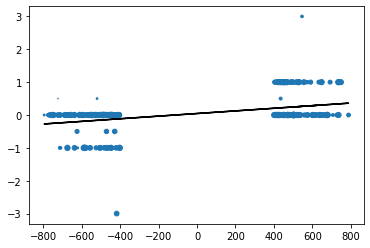

In [153]:
#Scatter plot of the conditional signal
from numpy.polynomial.polynomial import polyfit
y = rb1.MID
x = rb1.VOI
b, m = polyfit(x, y, 1)
size = np.random.rand(41227)*30
plt.scatter(x,y, size)
plt.plot(x, b + m * x, '-', color = 'black')
plt.plot()

In [204]:
rb = df[df.Contract1== 'rb'] #Took 1 contract as sample
pd.set_option('display.float_format', '{:.4f}'.format)
def threshold_ols(df):
    l = []
    t = []
    mse=[]
    df['VOI'] = VOI(df)
    df['MID'] = midprice(df).diff()
    df['pVOI'] = df.VOI/df.VOI.sum()
    for threshold in [0,0.005,0.01,0.015,0.02,0.025,0.03]:
        df = df[abs(df.pVOI) > threshold]
        y = df.MID
        x = sm.add_constant(df.VOI)
        try:
            res = sm.OLS(y,x).fit()
        except ValueError:  #raised if `y` is empty.
            pass
        pred = res.predict(x)
        l.append(round(res.rsquared,4))
        t.append(round(res.tvalues.VOI,4))
        mse.append(np.mean((y - pred)**2))
        liss = pd.DataFrame([l,t,mse])

    return liss

#df.groupby('Contract').apply(threshold_ols)
liss =threshold_ols(rb)
liss.columns = ['0','0.005','0.01','0.015','0.02','0.025','0.03']
liss.index = ['R^2','t(beta)','MSE']
print('Threshold Model')
liss


Threshold Model


C:\Users\Sam\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Sam\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Sam\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,0,0.005,0.01,0.015,0.02,0.025,0.03
R^2,0.0518,0.1337,0.1309,0.1209,0.1339,0.0981,0.0761
t(beta),37.4664,12.9720,5.9499,3.1687,2.0433,1.1893,0.8610
MSE,0.0510,0.1902,0.2541,0.3182,0.3028,0.3207,0.3818


Compared to the random walk model , the rb contract has R^2 of 0 and MSE of 0.0516. 

If we take a closer look to the result generted by the thresholded model. As the threshold increases, the R^2 increases up to 0.02 then decreases at the threshold grows bigger. The t-values of the signal is gradually weaker as threshold increases. Finally the MSE is much higher than the random walk model i.e. max at 0.3182 against 0.0516.

This observation suggested that although increasing threshold can reduce the sample size, it can also reduce the explantory power of the signal. In fact, not every signal are able to generate instantaoues price change.  